In [2]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
from PIL import Image
import albumentations as A
import gc
from albumentations.pytorch import ToTensorV2
from scipy.optimize import linear_sum_assignment
from rasterio.enums import Resampling

In [3]:
class BuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.image_ids = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)
        base_name = os.path.splitext(image_id)[0]
        mask_path = os.path.join(self.mask_dir, f"{base_name}_mask.tif")

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load instance mask
        mask = np.array(Image.open(mask_path))
        instance_ids = np.unique(mask)
        instance_ids = instance_ids[instance_ids != 0]  # exclude background (0)

        # Create binary masks per instance
        masks = mask == instance_ids[:, None, None]  # shape: [N, H, W]

        # Generate bounding boxes
        boxes = []
        valid_masks = []

        for mask in masks:
            pos = np.where(mask)
            if pos[0].size == 0 or pos[1].size == 0:
                continue  # Skip empty masks

            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if xmax <= xmin or ymax <= ymin:
                continue  # Skip invalid boxes

            boxes.append([xmin, ymin, xmax, ymax])
            valid_masks.append(mask)

        if len(valid_masks) == 0:
            # Handle case with no valid masks
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            masks = torch.zeros((0, img.shape[0], img.shape[1]), dtype=torch.uint8)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            labels = torch.ones((len(valid_masks),), dtype=torch.int64)  # 1 for building

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx]),
            "filename": [image_id]
        }

        img = torch.as_tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_ids)

In [4]:
dataset = BuildingDataset(
    image_dir='Dataset/train',
    mask_dir='Dataset/train_instances',
)

img, target = dataset[0]
print("Image shape:", img.shape)  # Should be [3, 512, 512]
print("Image type:", type(img))   # Should be torch.Tensor
print("Mask shape:", target["masks"].shape) # Should be [N, 512, 512]

Image shape: torch.Size([3, 2048, 2048])
Image type: <class 'torch.Tensor'>
Mask shape: torch.Size([153, 2048, 2048])


In [5]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

def get_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the box and mask heads
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)
    
    return model

In [6]:
model = get_model(num_classes=2)

C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Dataset and DataLoader
train_dataset = BuildingDataset('Dataset/train', 'Dataset/train_instances')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = BuildingDataset('Dataset/val', 'Dataset/val_instances')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

test_dataset = BuildingDataset('Dataset/test', 'Dataset/test_instances')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [8]:
from PIL import Image
import numpy as np

# Load mask
mask_path = 'Dataset/train_instances/Dataset.1_mask.tif'
mask = np.array(Image.open(mask_path))

# Check unique label values
unique_labels = np.unique(mask)
print("Labels in this mask:", unique_labels)

Labels in this mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]


In [9]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [10]:
def compute_iou_matrix(pred_masks, gt_masks): 
    num_preds = pred_masks.shape[0]
    num_gts = gt_masks.shape[0]
    iou_matrix = np.zeros((num_preds, num_gts), dtype=np.float32)

    for i in range(num_preds):
        p_mask = pred_masks[i].bool()
        for j in range(num_gts):
            g_mask = gt_masks[j].bool()
            intersection = (p_mask & g_mask).float().sum().item()
            union = (p_mask | g_mask).float().sum().item()
            if union > 0:
                iou_matrix[i, j] = intersection / union
    return iou_matrix

def evaluate_model(model, val_loader, device=None, iou_threshold=0.5, num_images=10, silent=False):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    iou_scores = []

    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            if i >= num_images:
                break

            if isinstance(images, list):  # For compatibility with your dataset
                image = images[0].to(device)
                target = targets[0]
            else:
                image = images.to(device)
                target = targets

            outputs = model([image])[0]

            pred_masks = outputs.get('masks')
            if pred_masks is None or len(pred_masks) == 0:
                iou_scores.append(0.0)
                # Memory cleanup
                del image, target, outputs
                torch.cuda.empty_cache()
                gc.collect()
                continue

            pred_masks = pred_masks.squeeze(1)          # Shape: [N, H, W]
            pred_masks = (pred_masks > 0.5).float()
            gt_masks = target['masks'].to(device)           # [M, H, W]
            gt_masks = (gt_masks > 0).float()

            if pred_masks.shape[0] == 0 or gt_masks.shape[0] == 0:
                iou_scores.append(0.0)
                # Memory cleanup
                del image, target, outputs, pred_masks, gt_masks
                torch.cuda.empty_cache()
                gc.collect()
                continue

            # Compute IoU matrix
            iou_matrix = compute_iou_matrix(pred_masks, gt_masks)

            # Hungarian matching
            cost_matrix = -iou_matrix
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            matched_ious = [
                iou_matrix[r, c]
                for r, c in zip(row_ind, col_ind)
                if iou_matrix[r, c] >= iou_threshold
            ]

            mean_iou = np.mean(matched_ious) if matched_ious else 0.0
            iou_scores.append(mean_iou)

            del image, target, outputs, pred_masks, gt_masks, iou_matrix, cost_matrix, row_ind, col_ind, matched_ious
            torch.cuda.empty_cache()
            gc.collect()

    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    if not silent:
        print(f"[Evaluation] Mean IoU over {min(num_images, len(val_loader))} images: {avg_iou:.4f}")

    return avg_iou

In [11]:
# === Load checkpoint if available ===
best_iou = 0.0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
checkpoint_path = 'Instance_model/MRCNNbest_model.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_iou = checkpoint['best_iou']
    print('Checkpoint loaded successfully.')

model.to(device)

Checkpoint loaded successfully.


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
model_dir = "Instance_model/"
save_name = "MRCNNbest_model.pth"
num_epochs = 30
early_stop_patience = 5
early_stop_counter = 0
os.makedirs(model_dir, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for batch in tqdm(train_loader, desc="Training"):
        if batch is None:
            continue
        
        images, targets = batch
        images = [img.to(device) for img in images]
        targets = [
            {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()}
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    lr_scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Avg Training Loss: {avg_loss:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

    # --- Evaluate on train and validation sets ---
    val_iou = evaluate_model(model, val_dataset, num_images=len(val_dataset), silent=True)
    
    print(f"Validation IoU: {val_iou:.4f}")

    # --- Save model checkpoint ---
    torch.save(model.state_dict(), f"{model_dir}model_epoch{epoch+1}.pth")

    if val_iou > best_iou:
        best_iou = val_iou
        checkpoint_path = os.path.join(model_dir, save_name)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'best_iou': best_iou
        }, checkpoint_path)
        print(f"Checkpoint saved with IoU: {best_iou:.4f} to {checkpoint_path}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch+1}") # Avoid overfitting
        break
    
    torch.cuda.empty_cache()
    gc.collect()

print(f"\nTraining complete. Best Validation IoU: {best_iou:.4f}")


Epoch 1/30


Training: 100%|██████████| 24/24 [00:43<00:00,  1.81s/it]


Avg Training Loss: 0.7644
Validation IoU: 0.8001

Epoch 2/30


Training: 100%|██████████| 24/24 [00:56<00:00,  2.37s/it]


Avg Training Loss: 0.7313
Validation IoU: 0.8006

Epoch 3/30


Training: 100%|██████████| 24/24 [01:01<00:00,  2.55s/it]


Avg Training Loss: 0.7226
Validation IoU: 0.7889

Epoch 4/30


Training: 100%|██████████| 24/24 [00:57<00:00,  2.38s/it]


Avg Training Loss: 0.6956
Validation IoU: 0.8005

Epoch 5/30


Training: 100%|██████████| 24/24 [01:01<00:00,  2.58s/it]


Avg Training Loss: 0.6767
Validation IoU: 0.7893
Early stopping triggered at epoch 5

Training complete. Best Validation IoU: 0.8053


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_classes=2)  # 2 = background + building
checkpoint = torch.load('Instance_model/MRCNNbest_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [15]:
def evaluate_testing(model, val_loader, device=None, iou_threshold=0.5, num_images=10, silent=False):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    iou_scores = []
    filenames = []

    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            if i >= num_images:
                break

            if isinstance(images, list):
                image = images[0].to(device)
                target = targets[0]
            else:
                image = images.to(device)
                target = targets
            
            filename = target.get('filename', [f"sample_{i}"])[0]

            outputs = model([image])[0]

            pred_masks = outputs.get('masks')
            if pred_masks is None or len(pred_masks) == 0:
                iou_scores.append(0.0)
                # Memory cleanup
                del image, target, outputs
                torch.cuda.empty_cache()
                gc.collect()
                continue

            pred_masks = pred_masks.squeeze(1)          # Shape: [N, H, W]
            pred_masks = (pred_masks > 0.5).float()
            gt_masks = target['masks'].to(device)           # [M, H, W]
            gt_masks = (gt_masks > 0).float()

            if pred_masks.shape[0] == 0 or gt_masks.shape[0] == 0:
                iou_scores.append(0.0)
                # Memory cleanup
                del image, target, outputs, pred_masks, gt_masks
                torch.cuda.empty_cache()
                gc.collect()
                continue

            # Compute IoU matrix
            iou_matrix = compute_iou_matrix(pred_masks, gt_masks)

            # Hungarian matching
            cost_matrix = -iou_matrix
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            matched_ious = [
                iou_matrix[r, c]
                for r, c in zip(row_ind, col_ind)
                if iou_matrix[r, c] >= iou_threshold
            ]

            mean_iou = np.mean(matched_ious) if matched_ious else 0.0
            iou_scores.append(mean_iou)
            filenames.append(filename)
            print(f"Sample {i+1} ({filename}): IoU = {mean_iou:.4f}")

            del image, target, outputs, pred_masks, gt_masks, iou_matrix, cost_matrix, row_ind, col_ind, matched_ious
            torch.cuda.empty_cache()
            gc.collect()

    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    if not silent:
        print(f"[Evaluation] Mean IoU over {min(num_images, len(val_loader))} images: {avg_iou:.4f}")

    return iou_scores

In [16]:
test_iou = evaluate_testing(model, test_dataset, num_images=len(test_dataset))

Sample 1 (Dataset.13.tif): IoU = 0.8151
Sample 2 (Dataset.25.tif): IoU = 0.8003
Sample 3 (Dataset.27.tif): IoU = 0.8485
Sample 4 (Dataset.3.tif): IoU = 0.7826
Sample 5 (Dataset.41.tif): IoU = 0.8096
Sample 6 (Dataset.51.tif): IoU = 0.8491
Sample 7 (Dataset.54.tif): IoU = 0.8035
Sample 8 (Dataset.8.tif): IoU = 0.8103
[Evaluation] Mean IoU over 8 images: 0.8149


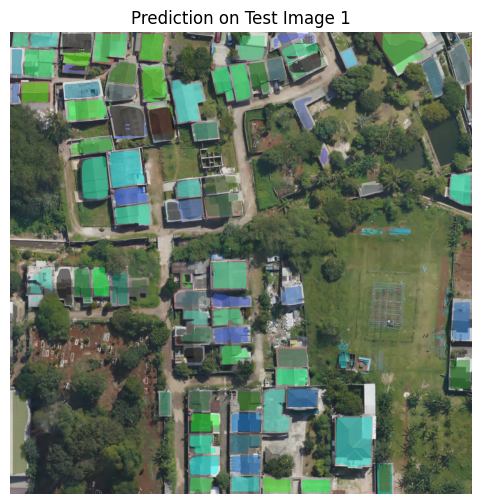

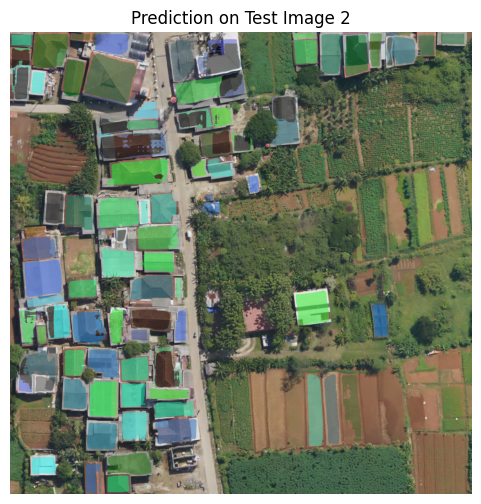

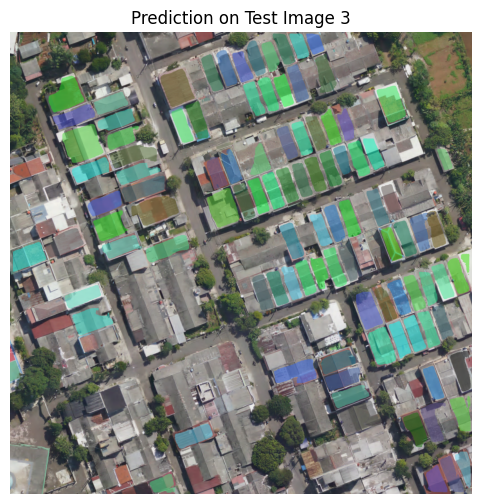

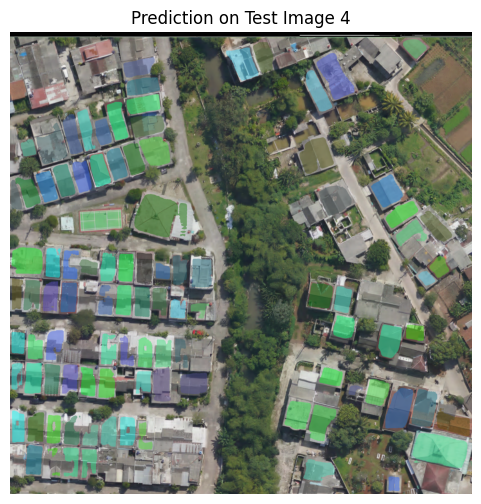

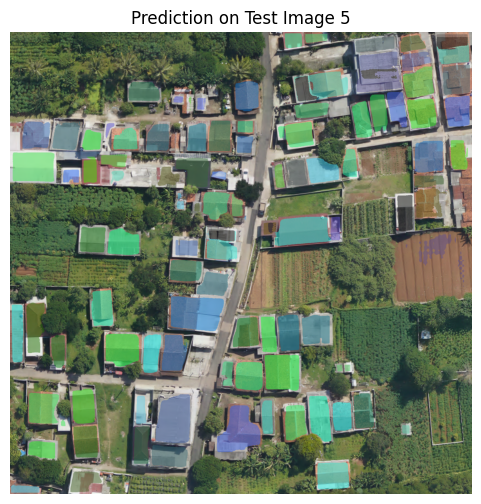

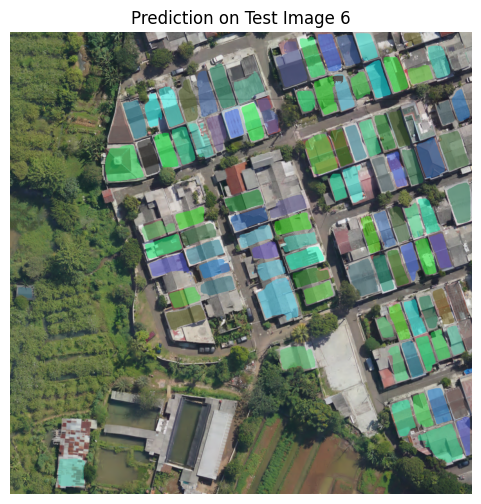

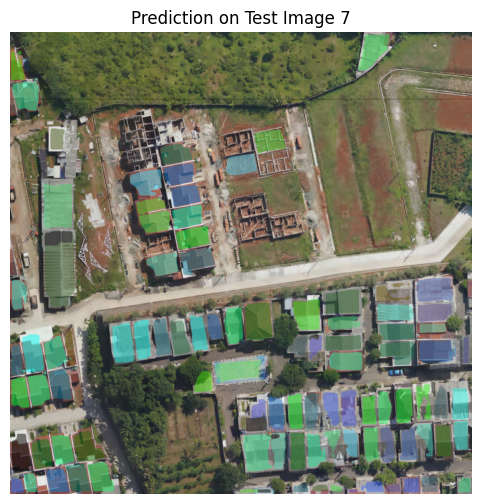

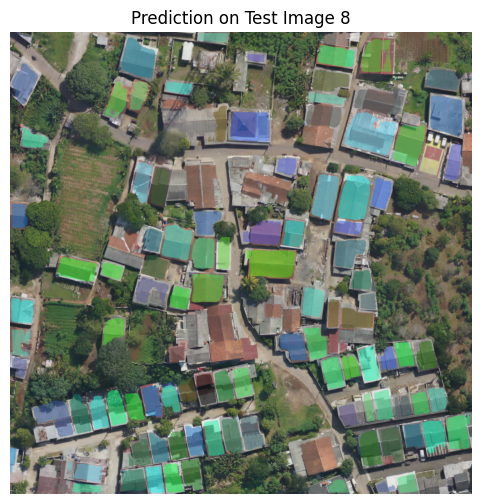

In [17]:
num_images=len(test_dataset)
model.eval()
device = next(model.parameters()).device

for i in range(min(num_images, len(test_dataset))):
    image, _ = test_dataset[i]
    image = image.to(device)

    with torch.no_grad():
        prediction = model([image])[0]

    masks = prediction['masks'] > 0.5
    if masks.shape[0] == 0:
        print(f"[{i}] No buildings detected.")
        continue

    mask_draw = draw_segmentation_masks(
        (image.cpu() * 255).byte(), masks.squeeze(1).cpu(), alpha=0.5
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_draw.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Prediction on Test Image {i+1}")
    plt.show()

In [18]:
output_dir = 'RCNN_predicted_masks'
os.makedirs(output_dir, exist_ok=True)

In [19]:
def export_predicted_masks(model, dataset, output_dir, threshold=0.5):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    device = next(model.parameters()).device

    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image_tensor = image.to(device)

        with torch.no_grad():
            output = model([image_tensor])[0]

        masks = output['masks'] > threshold
        if masks.shape[0] == 0:
            combined_mask = torch.zeros_like(image_tensor[0], dtype=torch.uint8)
        else:
            combined_mask = torch.any(masks.squeeze(1), dim=0).to(torch.uint8)

        pred_mask_np = combined_mask.cpu().numpy() * 255

        image_id = dataset.image_ids[idx]
        base_name = os.path.splitext(image_id)[0]
        pred_mask_filename = f"{base_name}_predicted.tif"
        compare_image_filename = f"{base_name}_compare.png"

        # === Extract spatial info from original GeoTIFF ===
        original_path = os.path.join(dataset.image_dir, image_id)  # Adjust if path is stored differently
        with rasterio.open(original_path) as src:
            crs = src.crs
            transform = src.transform
            height, width = pred_mask_np.shape

        # === Save predicted mask as GeoTIFF with CRS ===
        out_path = os.path.join(output_dir, pred_mask_filename)
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype='uint8',
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(pred_mask_np, 1)

        # === Visualization ===
        original_image = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        gt_mask = torch.any(target['masks'], dim=0).cpu().numpy().astype(np.uint8) * 255
        pred_mask = pred_mask_np

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(original_image)
        axs[0].set_title("Image")
        axs[1].imshow(gt_mask, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title("Predicted")
        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, compare_image_filename))
        plt.close()

        print(f"Saved: {pred_mask_filename}, {compare_image_filename}")

In [20]:
export_predicted_masks(model, test_dataset, output_dir)

Saved: Dataset.13_predicted.tif, Dataset.13_compare.png
Saved: Dataset.25_predicted.tif, Dataset.25_compare.png
Saved: Dataset.27_predicted.tif, Dataset.27_compare.png
Saved: Dataset.3_predicted.tif, Dataset.3_compare.png
Saved: Dataset.41_predicted.tif, Dataset.41_compare.png
Saved: Dataset.51_predicted.tif, Dataset.51_compare.png
Saved: Dataset.54_predicted.tif, Dataset.54_compare.png
Saved: Dataset.8_predicted.tif, Dataset.8_compare.png
